In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Load the dataset

In [2]:
df = pd.read_csv('../data/StudentPerformanceFactors.csv')
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


Preprocessing

In [3]:
df.columns = df.columns.str.lower()

In [4]:
categorical = df.dtypes[df.dtypes == 'object'].index.to_list()
categorical

['parental_involvement',
 'access_to_resources',
 'extracurricular_activities',
 'motivation_level',
 'internet_access',
 'family_income',
 'teacher_quality',
 'school_type',
 'peer_influence',
 'learning_disabilities',
 'parental_education_level',
 'distance_from_home',
 'gender']

In [5]:
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_').str.strip()

df.head()

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,23,84,low,high,no,7,73,low,yes,0,low,medium,public,positive,3,no,high_school,near,male,67
1,19,64,low,medium,no,8,59,low,yes,2,medium,medium,public,negative,4,no,college,moderate,female,61
2,24,98,medium,medium,yes,7,91,medium,yes,2,medium,medium,public,neutral,4,no,postgraduate,near,male,74
3,29,89,low,medium,yes,8,98,medium,yes,1,medium,medium,public,negative,4,no,high_school,moderate,male,71
4,19,92,medium,medium,yes,6,65,medium,yes,3,medium,high,public,neutral,4,no,college,near,female,70


Exploratory data analysis (EDA)

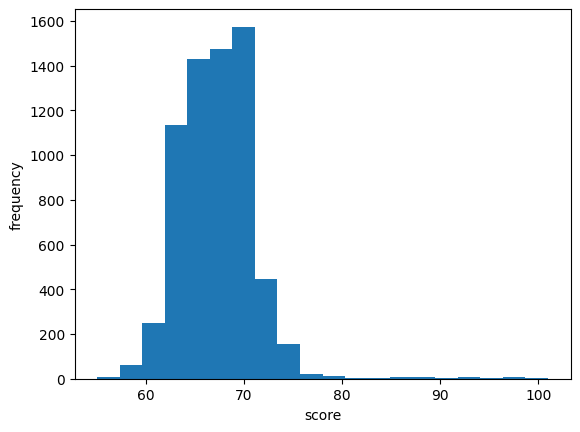

In [6]:
# Distribution of exam_score
plt.hist(df['exam_score'], bins=20)

plt.xlabel('score')
plt.ylabel('frequency')

plt.show()

In [7]:
# Columns with NaN values
df.isna().sum()[df.isna().sum() > 0]

teacher_quality             78
parental_education_level    90
distance_from_home          67
dtype: int64

In [8]:
# Size and % of records with NaN data
nan_records = int(((df['teacher_quality'].isna()) | (df['parental_education_level'].isna()) | (df['distance_from_home'].isna())).sum())
nan_records, nan_records/len(df)

(229, 0.03466020886938096)

In [9]:
for col in categorical:
    if df[col].isna().sum() > 0:
        print(col)
        mean_scores = df.groupby(col)['exam_score'].mean().sort_values()
        print(mean_scores)
        print()

teacher_quality
teacher_quality
low       66.753425
medium    67.109299
high      67.676939
Name: exam_score, dtype: float64

parental_education_level
parental_education_level
high_school     66.893577
college         67.315737
postgraduate    67.970881
Name: exam_score, dtype: float64

distance_from_home
distance_from_home
far         66.457447
moderate    66.981481
near        67.512101
Name: exam_score, dtype: float64



Given that:

- The differences between categories are all around between 66-68, and
- Only ~3.5% of records are missing,

It’s perfectly reasonable (and safe) to replace the NaN values with "Unknown" in this case.

In [10]:
# Replace NaN with "Unknown"
df = df.fillna('Unknown')

Setting up the validation framework

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

len(df_train), len(df_val), len(df_test)

(3963, 1322, 1322)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train['exam_score']
y_val = df_val['exam_score']
y_test = df_test['exam_score']

del df_train['exam_score']
del df_val['exam_score']
del df_test['exam_score']

Feature importance

a. Average ratio

In [15]:
average_score = df_full_train['exam_score'].mean()
average_score

np.float64(67.2151371807001)

In [16]:
from IPython.display import display

for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c)['exam_score'].agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - average_score
    df_group['ratio'] = df_group['mean'] / average_score
    display(df_group)
    print()
    print()



parental_involvement


,mean,count,diff,ratio
parental_involvement,,,,
high,68.085302,1524,0.870165,1.012946
low,66.371615,1071,-0.843522,0.987450
medium,67.057993,2690,-0.157145,0.997662




access_to_resources


,mean,count,diff,ratio
access_to_resources,,,,
high,68.112102,1570,0.896965,1.013345
low,66.158745,1052,-1.056392,0.984283
medium,67.103643,2663,-0.111495,0.998341




extracurricular_activities


,mean,count,diff,ratio
extracurricular_activities,,,,
no,66.848728,2122,-0.366410,0.994549
yes,67.460955,3163,0.245818,1.003657




motivation_level


,mean,count,diff,ratio
motivation_level,,,,
high,67.638114,1039,0.422976,1.006293
low,66.796534,1558,-0.418603,0.993772
medium,67.294271,2688,0.079134,1.001177




internet_access


,mean,count,diff,ratio
internet_access,,,,
no,66.533981,412,-0.681157,0.989866
yes,67.272727,4873,0.057590,1.000857




family_income


,mean,count,diff,ratio
family_income,,,,
high,67.877349,1011,0.662212,1.009852
low,66.841566,2146,-0.373571,0.994442
medium,67.277256,2128,0.062118,1.000924




teacher_quality


,mean,count,diff,ratio
teacher_quality,,,,
Unknown,66.766667,60,-0.448471,0.993328
high,67.678366,1567,0.463229,1.006892
low,66.771760,517,-0.443377,0.993404
medium,67.065584,3141,-0.149553,0.997775




school_type


,mean,count,diff,ratio
school_type,,,,
private,67.314607,1602,0.099470,1.001480
public,67.171871,3683,-0.043266,0.999356




peer_influence


,mean,count,diff,ratio
peer_influence,,,,
negative,66.555154,1106,-0.659983,0.990181
neutral,67.186482,2027,-0.028655,0.999574
positive,67.581320,2152,0.366183,1.005448




learning_disabilities


,mean,count,diff,ratio
learning_disabilities,,,,
no,67.341412,4704,0.126274,1.001879
yes,66.192771,581,-1.022366,0.984790




parental_education_level


,mean,count,diff,ratio
parental_education_level,,,,
Unknown,66.985507,69,-0.229630,0.996584
college,67.262958,1582,0.047821,1.000711
high_school,66.870320,2591,-0.344817,0.994870
postgraduate,68.014382,1043,0.799244,1.011891




distance_from_home


,mean,count,diff,ratio
distance_from_home,,,,
Unknown,66.098039,51,-1.117098,0.983380
far,66.433645,535,-0.781492,0.988373
moderate,66.972032,1609,-0.243105,0.996383
near,67.495469,3090,0.280332,1.004171




gender


,mean,count,diff,ratio
gender,,,,
female,67.214254,2231,-0.000883,0.999987
male,67.215783,3054,0.000645,1.000010


b. Mutual information

In [17]:
from sklearn.metrics import mutual_info_score

In [18]:
def mutual_info_exam_score(series):
    return mutual_info_score(series, df_full_train['exam_score'])

In [19]:
mi = df_full_train[categorical].apply(mutual_info_exam_score)
mi.sort_values(ascending=False)

access_to_resources           0.029832
parental_involvement          0.024106
parental_education_level      0.020185
distance_from_home            0.016436
peer_influence                0.013841
family_income                 0.013510
teacher_quality               0.013318
motivation_level              0.010861
learning_disabilities         0.010347
extracurricular_activities    0.008098
gender                        0.005921
internet_access               0.005045
school_type                   0.005035
dtype: float64

c. Correlation

In [20]:
numerical = [x for x in df_full_train.columns if x not in categorical + ['exam_score']]
numerical

['hours_studied',
 'attendance',
 'sleep_hours',
 'previous_scores',
 'tutoring_sessions',
 'physical_activity']

In [21]:
df_full_train[numerical].corrwith(df_full_train['exam_score']).abs().sort_values(ascending=False)

attendance           0.579000
hours_studied        0.436510
previous_scores      0.172939
tutoring_sessions    0.156122
physical_activity    0.035173
sleep_hours          0.023253
dtype: float64

One-hot encoding

In [22]:
from sklearn.feature_extraction import DictVectorizer

In [23]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.transform(full_train_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_full_train = df_full_train['exam_score']


Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [25]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [26]:
y_pred = lr_model.predict(X_val)
lr_rmse = root_mean_squared_error(y_val, y_pred)
lr_rmse

2.2632622421937065

In [27]:
student = df_test.loc[15].to_dict()

X_student = dv.transform(student)
predicted_score = lr_model.predict(X_student)
y_test[15], predicted_score[0]

(np.int64(63), np.float64(63.533484195280245))

Decision Tree Regressor

In [28]:
from sklearn.tree import DecisionTreeRegressor

In [29]:
scores = []

for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dtr_model = DecisionTreeRegressor(max_depth=d, random_state=42)
    dtr_model.fit(X_train, y_train)
    y_pred = dtr_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)
    scores.append((d, score))

In [30]:
columns = ['max_depth', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

,max_depth,score
5,6.0,2.872827
4,5.0,2.921940
3,4.0,2.963087
2,3.0,3.032511
1,2.0,3.207019


In [31]:
scores = []
for d in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 100, 200, 500]:
        dtr_model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=42)
        dtr_model.fit(X_train, y_train)
        y_pred = dtr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)
        scores.append((d, s, score))

In [32]:
pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'score']).sort_values(by='score').head(10)

,max_depth,min_samples_leaf,score
19,6,15,2.870233
17,6,5,2.872669
16,6,1,2.872827
20,6,20,2.873850
18,6,10,2.877796
12,5,20,2.921465
8,5,1,2.921940
9,5,5,2.926450
11,5,15,2.928127
10,5,10,2.928127


In [33]:
max_depth = 6
min_samples_leaf = 15

In [34]:
dtr_model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
dtr_model.fit(X_train, y_train)
y_pred = dtr_model.predict(X_val)
dtr_rmse = root_mean_squared_error(y_val, y_pred)
dtr_rmse

2.8702331060560415

In [35]:
predicted_score = dtr_model.predict(X_student)
y_test[15], predicted_score[0]

(np.int64(63), np.float64(61.15625))

Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
scores = []

for n in range(10, 201, 10):
    rf_model = RandomForestRegressor(n_estimators=n, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)
    
    scores.append((n, score))

In [38]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

In [39]:
df_scores.sort_values(by='score').head()

,n_estimators,score
9,100,2.548008
14,150,2.550779
18,190,2.551169
19,200,2.551501
7,80,2.552394


In [40]:
scores = []

for d in [2, 3, 4, 5, 10, 15, None]:
    for n in range(10, 201, 10):
        rfr_model = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=42)
        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, score))

In [41]:
columns = ['max_depth', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='score').head()

,max_depth,n_estimators,score
129,NaN,100,2.548008
114,15.0,150,2.550159
134,NaN,150,2.550779
119,15.0,200,2.550861
138,NaN,190,2.551169


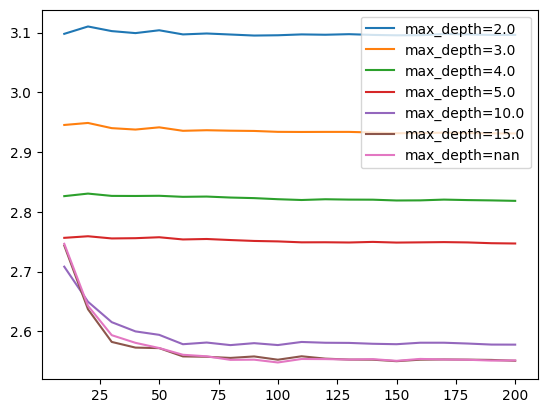

In [42]:
for d in df_scores['max_depth'].unique():
    if pd.isna(d):
        df_subset = df_scores[df_scores['max_depth'].isna()]
        label = 'max_depth=nan'
    else:
        df_subset = df_scores[df_scores['max_depth'] == d]
        label = f'max_depth={d}'
    
    plt.plot(df_subset['n_estimators'], df_subset['score'], label=label)

plt.legend()

In [43]:
max_depth = 15

In [44]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rfr_model = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=42)
        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((s, n, score))

In [45]:
columns = ['min_samples_leaf', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

,min_samples_leaf,n_estimators,score
29,3,100,2.518255
39,3,200,2.519667
27,3,80,2.520282
38,3,190,2.520506
34,3,150,2.520717


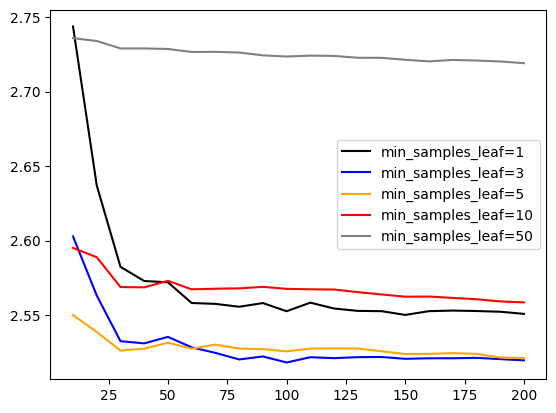

In [46]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.score,
             color=col,
             label=f'min_samples_leaf={s}')

plt.legend()

In [47]:
min_samples_leaf = 3

In [48]:
scores = []

for n in range(10, 201, 10):
    rfr_model = RandomForestRegressor(n_estimators=n,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                random_state=42)
    rfr_model.fit(X_train, y_train)

    y_pred = rfr_model.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)

    scores.append((n, score))

In [49]:
columns = ['n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.sort_values(by='score').head()

,n_estimators,score
9,100,2.518255
19,200,2.519667
7,80,2.520282
18,190,2.520506
14,150,2.520717


In [50]:
n_estimators = 100

In [51]:
rfr_model = RandomForestRegressor(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42)
rfr_model.fit(X_train, y_train)

y_pred = rfr_model.predict(X_val)
rfr_score = root_mean_squared_error(y_val, y_pred)
rfr_score

2.5182545523743896

In [52]:
predicted_score = rf_model.predict(X_student)
y_test[15], predicted_score

(np.int64(63), array([63.265]))

XGBoost

In [53]:
import xgboost as xgb

In [54]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, feature_names=features)

In [55]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [56]:
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = xgb_model.predict(dval)


In [57]:
root_mean_squared_error(y_val, y_pred)

2.5367319583892822

In [58]:
# XGBoost parameter tuning


In [59]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [60]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [61]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_score']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [62]:
scores = {}

In [84]:
%%capture output
eta = 1 # replace values manually for eta=0.01, eta=0.02, eta=0.05, eta=0.1, eta=0.3, eta=0.5, eta=0.8, eta=1

xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}



xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2000,
                  verbose_eval=5,
                  evals=watchlist)


In [85]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1'

In [86]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.02', 'eta=0.05', 'eta=0.1', 'eta=0.3', 'eta=0.5', 'eta=0.8', 'eta=1'])

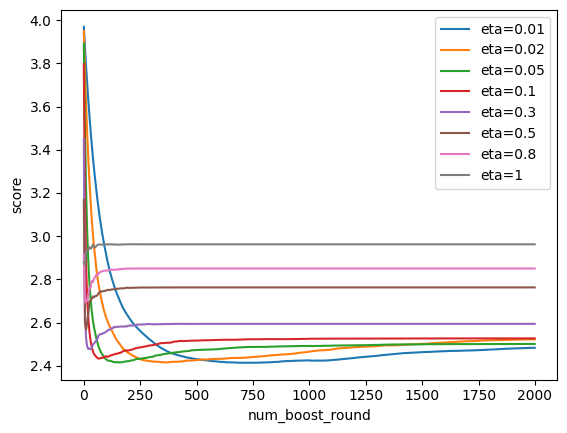

In [87]:
for eta in scores.keys():
    df_scores = scores[eta]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=eta)
plt.xlabel('num_boost_round')
plt.ylabel('score')
plt.legend()

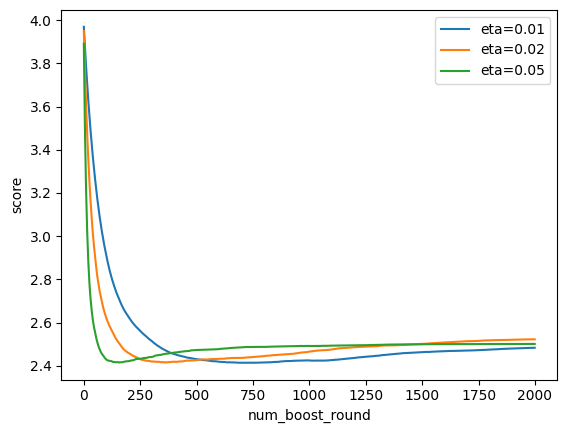

In [88]:
# Remove eta=0.1, eta=0.3, eta=0.5, eta=0.8 and eta=1 for a better visualization.
etas = [x for x in scores.keys() if x not in ['eta=0.1', 'eta=0.3', 'eta=0.5', 'eta=0.8', 'eta=1']]
for eta in etas:
    df_scores = scores[eta]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=eta)
plt.xlabel('num_boost_round')
plt.ylabel('score')
plt.legend()

In [89]:
df_scores = pd.DataFrame()
for key in scores.keys():
    df_tmp = scores[key]
    df_tmp['eta'] = key.split('=')[1]
    df_scores = pd.concat([df_scores, df_tmp])

df_scores.sort_values(by='val_score').head(10)


,num_iter,train_auc,val_score,eta
151,755,1.09338,2.41386,0.01
143,715,1.12139,2.41393,0.01
152,760,1.08949,2.41400,0.01
138,690,1.13938,2.41402,0.01
141,705,1.12873,2.41405,0.01
139,695,1.13578,2.41406,0.01
142,710,1.12498,2.41407,0.01
140,700,1.13270,2.41410,0.01
153,765,1.08560,2.41415,0.01
144,720,1.11731,2.41417,0.01


Best eta after 750 num_boost_round
eta = 0.01

In [90]:
scores = {}

In [103]:
%%capture output
max_depth = 10 # replace values manually for max_depth=6, max_depth=3, max_depth=4, max_depth=8, max_depth=10

xgb_params = {
    'eta': 0.01, 
    'max_depth': max_depth,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2500,
                  verbose_eval=5,
                  evals=watchlist)


In [104]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [105]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=8', 'max_depth=10'])

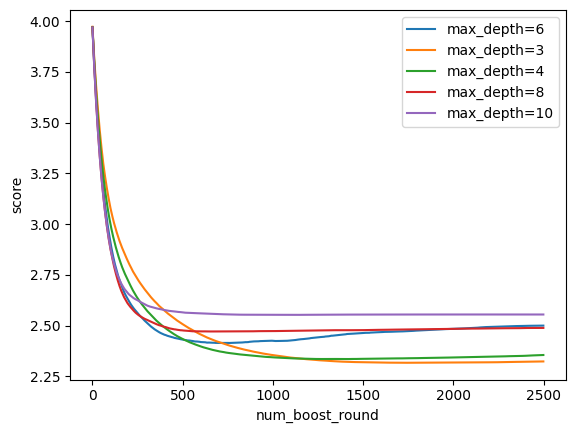

In [106]:
for max_depth in scores.keys():
    df_scores = scores[max_depth]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=max_depth)
plt.xlabel('num_boost_round')
plt.ylabel('score')
# plt.ylim(2.5, 2.7)
plt.legend()

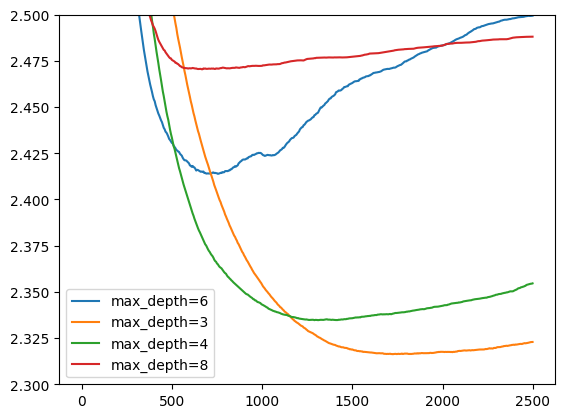

In [107]:
# Remove max_depth=10 and zoom the graph between scores of 2.3-2.5 for a better visualization.
max_depths = [x for x in scores.keys() if x not in ['max_depth=10']]
for max_depth in max_depths:
    df_scores = scores[max_depth]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=max_depth)
plt.ylim(2.3, 2.5)
plt.legend()

In [108]:
df_scores = pd.DataFrame()
for key in scores.keys():
    df_tmp = scores[key]
    df_tmp['max_depth'] = key.split('=')[1]
    df_scores = pd.concat([df_scores, df_tmp])

df_scores.sort_values(by='val_score').head(10)


,num_iter,train_auc,val_score,max_depth
345,1725,1.74427,2.31628,3
343,1715,1.74564,2.31636,3
349,1745,1.74142,2.31636,3
344,1720,1.74493,2.31638,3
350,1750,1.74083,2.31638,3
356,1780,1.73709,2.31638,3
346,1730,1.74367,2.31639,3
338,1690,1.74909,2.31639,3
352,1760,1.73948,2.31639,3
363,1815,1.73287,2.31639,3


max_depth = 3 # after num_boost_round 1500. Overfitting after 2000?

In [109]:
scores = {}

In [116]:
%%capture output
min_child_weight = 30 # replace values manually for min_child_weight=1, min_child_weight=10, min_child_weight=30

xgb_params = {
    'eta': 0.01, 
    'max_depth': 3,
    'min_child_weight': min_child_weight,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2500,
                  verbose_eval=5,
                  evals=watchlist)


In [117]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [118]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

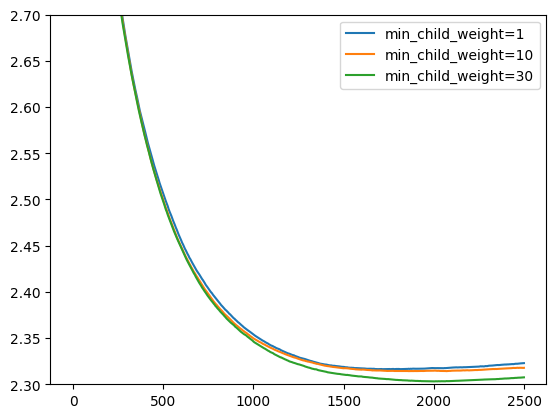

In [119]:
min_child_weights = [x for x in scores.keys() if x not in []]
for min_child_weight in min_child_weights:
    df_scores = scores[min_child_weight]
    plt.plot(df_scores['num_iter'], df_scores['val_score'], label=min_child_weight)
plt.ylim(2.3, 2.7)

plt.legend()

In [120]:
df_scores = pd.DataFrame()
for key in scores.keys():
    df_tmp = scores[key]
    df_tmp['max_depth'] = key.split('=')[1]
    df_scores = pd.concat([df_scores, df_tmp])

df_scores.sort_values(by='val_score').head(10)


,num_iter,train_auc,val_score,max_depth
401,2005,1.82259,2.30313,30
398,1990,1.82355,2.30313,30
400,2000,1.82285,2.30313,30
399,1995,1.82331,2.30316,30
404,2020,1.82146,2.30318,30
396,1980,1.82422,2.30320,30
407,2035,1.82057,2.30321,30
403,2015,1.82185,2.30321,30
395,1975,1.82461,2.30325,30
406,2030,1.82079,2.30326,30


min_child_weight = 30 # after aprox. 2000 num_boost_round

In [123]:
num_boost_rounds = np.linspace(700, 2500, 19).astype('int')
scores = []

for n in num_boost_rounds:
    xgb_params = {
        'eta': 0.01, 
        'max_depth': 3,
        'min_child_weight': 30,
        
        'objective': 'reg:squarederror',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    watchlist = [(dtrain, 'train'), (dval, 'val')]

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=n)

    y_pred = xgb_model.predict(dval)

    score = root_mean_squared_error(y_val, y_pred)

    scores.append(score)


In [124]:
for n, s in zip(num_boost_rounds, scores):
    print(n, ' -> ', s)

700  ->  2.4098782539367676
800  ->  2.3825550079345703
900  ->  2.3623249530792236
1000  ->  2.3464553356170654
1100  ->  2.3345799446105957
1200  ->  2.3248069286346436
1300  ->  2.3184351921081543
1400  ->  2.313699960708618
1500  ->  2.3104617595672607
1600  ->  2.3084075450897217
1700  ->  2.306131362915039
1800  ->  2.3046915531158447
1900  ->  2.303649425506592
2000  ->  2.3030784130096436
2100  ->  2.303572654724121
2200  ->  2.3043532371520996
2300  ->  2.305260419845581
2400  ->  2.3062143325805664
2500  ->  2.3074984550476074


num_boost_round = 2000

In [125]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=2000)


In [126]:
y_pred = xgb_model.predict(dval)

In [127]:
xgb_rmse = root_mean_squared_error(y_val, y_pred)
xgb_rmse

2.3030784130096436

In [128]:
dstudent = xgb.DMatrix(X_student, feature_names=features)
predicted_score = xgb_model.predict(dstudent)
y_test[15], predicted_score

(np.int64(63), array([63.943474], dtype=float32))

Build the final model

In [129]:
lr_rmse, dtr_rmse, rfr_score, xgb_rmse

(2.2632622421937065,
 2.8702331060560415,
 2.5182545523743896,
 2.3030784130096436)

The best is: Linear Regression Model

In [130]:
lr_model = LinearRegression()
lr_model.fit(X_full_train, y_full_train)

y_pred = lr_model.predict(X_test)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_rmse

1.803352774026728

In [131]:
df_student = df_test.iloc[52]
student_dict = df_student[categorical + numerical].to_dict()
X_student = dv.transform(student_dict)
score_prediction = lr_model.predict(X_student)
score_prediction, y_test[52]

(array([61.67849522]), np.int64(61))

Save the model

In [132]:
from sklearn.pipeline import make_pipeline

In [133]:
pipeline = make_pipeline(
    DictVectorizer(), 
    LinearRegression()
)

In [134]:
pipeline.fit(full_train_dict, y_full_train)

,steps,"[('dictvectorizer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,True
,sort,True
,fit_intercept,True
,copy_X,True
,tol,1e-06


In [135]:
pipeline.predict(student_dict)

array([61.67836684])

In [136]:
import pickle

In [137]:
with open('model.bin', 'wb') as f_out:
    pickle.dump(pipeline, f_out)

Make prediction

In [138]:
import pickle

with open('model.bin', 'rb') as f_in:
    pipeline = pickle.load(f_in)

In [139]:
student = {
    'hours_studied': 15,
    'attendance': 66,
    'parental_involvement': 'medium',
    'access_to_resources': 'low',
    'extracurricular_activities': 'yes',
    'sleep_hours': 4,
    'previous_scores': 90,
    'motivation_level': 'low',
    'internet_access': 'yes',
    'tutoring_sessions': 2,
    'family_income': 'medium',
    'teacher_quality': 'high',
    'school_type': 'public',
    'peer_influence': 'negative',
    'physical_activity': 7,
    'learning_disabilities': 'no',
    'parental_education_level': 'college',
    'distance_from_home': 'far',
    'gender': 'female'
}

pipeline.predict(student)

array([62.87297377])